In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.metrics import classification_report, confusion_matrix

# deep learning libraries
import tensorflow as tf
import keras
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import applications
from keras.models import Sequential, load_model
from keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D, Flatten, Dense, Dropout
from keras.preprocessing import image
import keras.utils as image
import cv2

import warnings
warnings.filterwarnings('ignore')

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
directory_train = 'drive/MyDrive/Covid_dataset/Train'
directory_validation = 'drive/MyDrive/Covid_dataset/Val'
directory_test = 'drive/MyDrive/Covid_dataset/Prediction'

In [ ]:
# Data agumentation and pre-processing using tensorflow
gen = ImageDataGenerator(
    rescale=1./255.,
    horizontal_flip = True,
    vertical_flip = True
)

In [ ]:
train_generator = gen.flow_from_directory(
    directory = directory_train,
    color_mode="rgb",
    target_size = (331,331), # image height , image width
    class_mode="categorical",
    batch_size=8,
    shuffle=True
)

Found 288 images belonging to 2 classes.


In [ ]:
validation_generator = gen.flow_from_directory(
    directory = directory_validation, 
    color_mode="rgb",
    target_size = (331,331), # image height , image width
    class_mode="categorical",
    batch_size=8,
    shuffle=True
)

Found 60 images belonging to 2 classes.


In [ ]:
x,y = next(train_generator)
x.shape # input shape of one record is (331,331,3) , 8: is the batch size

(8, 331, 331, 3)

In [ ]:
a = train_generator.class_indices
class_names = list(a.keys()) # storing class/breed names in a list

def plot_images(img,labels):
    plt.figure(figsize=[15,10])
    for i in range(6):
        plt.subplot(2,3,i+1)
        plt.imshow(img[i])
        plt.title(class_names[np.argmax(labels[i])])
        plt.axis('off')

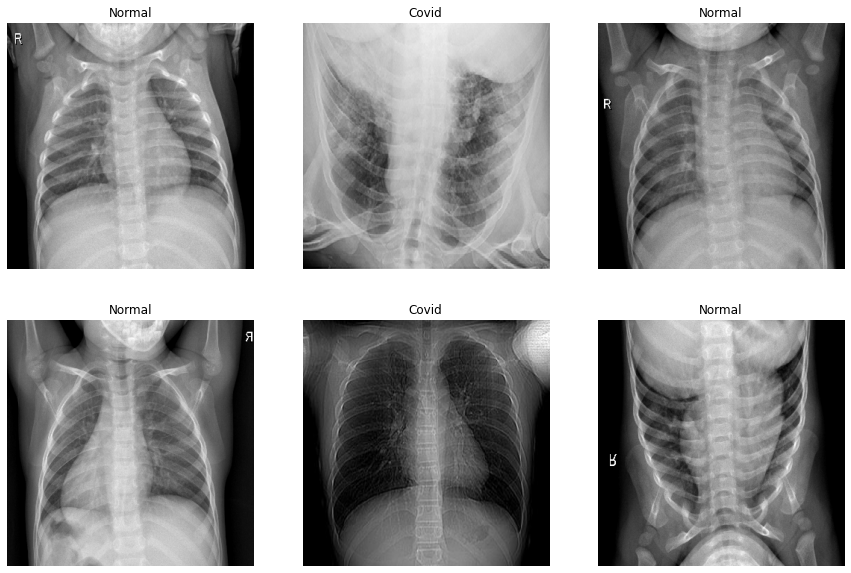

In [ ]:
plot_images(x,y)

In [ ]:
# load the InceptionResNetV2 architecture with imagenet weights as base
base_model = tf.keras.applications.VGG16(
    include_top=False,
    weights='imagenet',
    input_shape=(331,331,3)
)

base_model.trainable=False
model = tf.keras.Sequential([
    base_model,
    tf.keras.layers.BatchNormalization(renorm=True),
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(120, activation='softmax'),
    tf.keras.layers.Dense(2, activation='softmax')
])
model.compile(optimizer='Adam',loss='categorical_crossentropy',metrics=['categorical_accuracy'])


58889256/58889256 [==============================] - 0s 0us/step


In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 10, 10, 512)       14714688  
                                                                 
 batch_normalization (BatchN  (None, 10, 10, 512)      3584      
 ormalization)                                                   
                                                                 
 global_average_pooling2d (G  (None, 512)              0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 512)               262656    
                                                                 
 dense_1 (Dense)             (None, 256)               131328    
                                                                 
 dropout (Dropout)           (None, 256)               0

In [ ]:
early = tf.keras.callbacks.EarlyStopping( patience=10,
                                         min_delta=0.001,
                                         restore_best_weights=True)

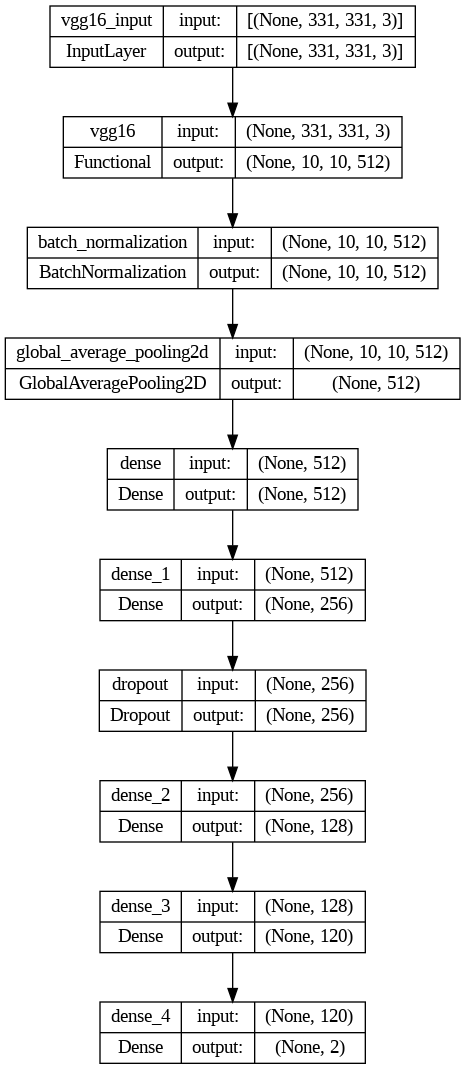

In [ ]:
tf.keras.utils.plot_model(model, to_file='model.png', show_shapes=True)

In [ ]:
batch_size=8
STEP_SIZE_TRAIN = train_generator.n//train_generator.batch_size
STEP_SIZE_VALID = validation_generator.n//validation_generator.batch_size

# fit model
history = model.fit(train_generator,
                    steps_per_epoch=STEP_SIZE_TRAIN,
                    validation_data=validation_generator,
                    validation_steps=STEP_SIZE_VALID,
                    epochs=25,
                    callbacks=[early]
)

Epoch 1/25
36/36 [==============================] - 358s 10s/step - loss: 0.6669 - categorical_accuracy: 0.5868 - val_loss: 0.5790 - val_categorical_accuracy: 0.9107
Epoch 2/25
36/36 [==============================] - 338s 9s/step - loss: 0.5456 - categorical_accuracy: 0.9097 - val_loss: 0.4989 - val_categorical_accuracy: 0.9821
Epoch 3/25
36/36 [==============================] - 339s 9s/step - loss: 0.4923 - categorical_accuracy: 0.9514 - val_loss: 0.4629 - val_categorical_accuracy: 0.9821
Epoch 4/25
36/36 [==============================] - 337s 9s/step - loss: 0.4576 - categorical_accuracy: 0.9618 - val_loss: 0.4475 - val_categorical_accuracy: 0.9643
Epoch 5/25
36/36 [==============================] - 339s 9s/step - loss: 0.4371 - categorical_accuracy: 0.9583 - val_loss: 0.4170 - val_categorical_accuracy: 0.9821
Epoch 6/25
36/36 [==============================] - 344s 10s/step - loss: 0.4028 - categorical_accuracy: 0.9792 - val_loss: 0.3773 - val_categorical_accuracy: 1.0000
Epoch 7/

In [ ]:
# store results
acc = history.history['categorical_accuracy']
val_acc = history.history['val_categorical_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

Text(0.5, 1.0, '\nTraining and Validation Accuracy. \nTrain Accuracy: 0.9791666865348816 \nValidation Accuracy: 0.9821428656578064')

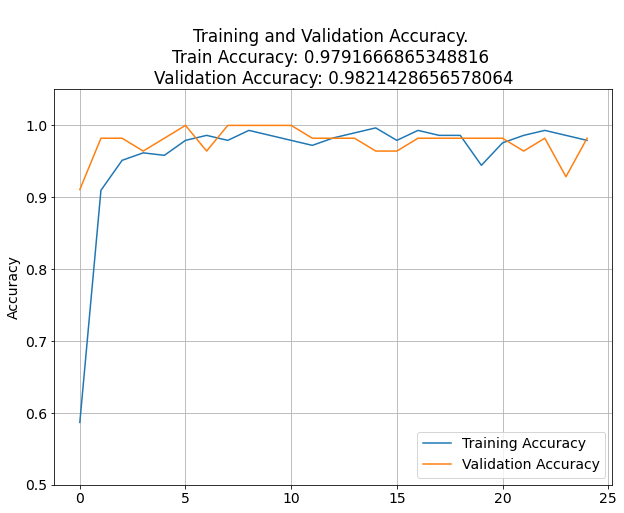

In [ ]:
# plot results
# accuracy
plt.figure(figsize=(10, 16))
plt.rcParams['figure.figsize'] = [16, 9]
plt.rcParams['font.size'] = 14
plt.rcParams['axes.grid'] = True
plt.rcParams['figure.facecolor'] = 'white'
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([0.5,1.05])
plt.title(f'\nTraining and Validation Accuracy. \nTrain Accuracy: {(str(acc[-1]))} \nValidation Accuracy: {str(val_acc[-1])}')

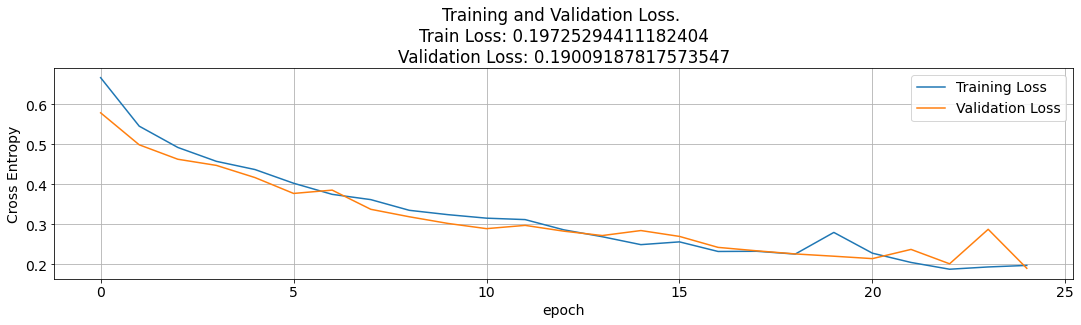

In [ ]:
# loss
plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.title(f'Training and Validation Loss. \nTrain Loss: {str(loss[-1])}\nValidation Loss: {str(val_loss[-1])}')
plt.xlabel('epoch')
plt.tight_layout(pad=3.0)
plt.show()

In [ ]:
accuracy_score = model.evaluate(validation_generator)
print(accuracy_score)
print("Accuracy: {:.4f}%".format(accuracy_score[1] * 100))

print("Loss: ",accuracy_score[0])

8/8 [==============================] - 68s 8s/step - loss: 0.1880 - categorical_accuracy: 0.9833
[0.18801356852054596, 0.9833333492279053]
Accuracy: 98.3333%
Loss:  0.18801356852054596


In [ ]:
import os

images = []
for img in os.listdir(directory_test):
    img = os.path.join(directory_test, img)
    img = image.load_img(img, target_size=(331, 331))
    img = image.img_to_array(img)
    img = np.expand_dims(img, axis=0)
    img = img/255
    images.append(img)

In [ ]:
images = np.vstack(images)
classes = model.predict(images)
print(classes)

1/1 [==============================] - 41s 41s/step
[[0.14710818 0.8528918 ]
 [0.14710818 0.8528918 ]
 [0.85359824 0.14640172]
 [0.14710818 0.8528918 ]
 [0.85359824 0.14640172]
 [0.14710818 0.8528918 ]
 [0.14710818 0.8528918 ]
 [0.85359824 0.14640172]
 [0.14710818 0.8528918 ]
 [0.14710818 0.8528918 ]
 [0.85359824 0.14640172]
 [0.85359824 0.14640172]
 [0.85359824 0.14640172]
 [0.85359824 0.14640172]
 [0.14710818 0.8528918 ]
 [0.14710818 0.8528918 ]
 [0.85359824 0.1464017 ]
 [0.85359824 0.1464017 ]
 [0.85359824 0.1464017 ]
 [0.14710815 0.8528918 ]
 [0.85359824 0.1464017 ]
 [0.14710815 0.8528918 ]
 [0.14710815 0.8528918 ]]


In [ ]:
Y_pred = model.predict_generator(validation_generator, 60 // batch_size+1)
y_pred = np.argmax(Y_pred, axis=1)
print('Confusion Matrix')
print(confusion_matrix(validation_generator.classes, y_pred))
print('Classification Report')
target_names = ['Covid', 'Normal']
print(classification_report(validation_generator.classes, y_pred, target_names=target_names))

Confusion Matrix
[[14 16]
 [15 15]]
Classification Report
              precision    recall  f1-score   support

       Covid       0.48      0.47      0.47        30
      Normal       0.48      0.50      0.49        30

    accuracy                           0.48        60
   macro avg       0.48      0.48      0.48        60
weighted avg       0.48      0.48      0.48        60

